In [2]:
import polars as pl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import sqrt, dot
import seaborn as sns
from sklearn.model_selection import train_test_split
from kennard_stone import train_test_split as train_test_split_ks

In [3]:
sns.set_theme()

In [ ]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):

    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):

    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

def F(y_pred: pl.Series, y_obs: pl.DataFrame, descriptor_number: int):

    return (((y_pred - y_pred.mean())**2).sum() / (y_pred.shape[0] - 1)) / (((y_obs.to_series() - y_pred)**2).sum() / (y_pred.shape[0] - descriptor_number - 1))

In [5]:
partitioning_methods = ("premade", "random", "KS", "1:X")

In [6]:
input_matrix = pl.read_excel(
                source="dane_leki.xlsx",
                columns=list(range(1,8))
)

In [7]:
input_matrix.head()

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA,Zbiór
str,f64,f64,i64,i64,i64,str
"""acetaminophen""",-0.79,-0.63,2,0,2,"""t"""
"""acetylsalicylic acid""",-0.23,1.22,1,0,4,"""t"""
"""bromazepam""",0.38,0.57,1,0,3,"""t"""
"""carbamazepine""",0.69,0.68,0,0,3,"""t"""
"""chlorpromazine""",1.18,1.5,0,0,2,"""t"""


In [8]:
Y = input_matrix.select(pl.col('Nazwa'), pl.col("logK HSA"))

In [9]:
Y.head()

Nazwa,logK HSA
str,f64
"""acetaminophen""",-0.79
"""acetylsalicylic acid""",-0.23
"""bromazepam""",0.38
"""carbamazepine""",0.69
"""chlorpromazine""",1.18


In [10]:
X = input_matrix.select(
    pl.exclude(["logK HSA", "Zbiór"])
)

In [11]:
X.head()

Nazwa,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,i64,i64,i64
"""acetaminophen""",-0.63,2,0,2
"""acetylsalicylic acid""",1.22,1,0,4
"""bromazepam""",0.57,1,0,3
"""carbamazepine""",0.68,0,0,3
"""chlorpromazine""",1.5,0,0,2


In [12]:
X_training, Y_training, X_validation, Y_validation = {}, {}, {}, {}

Inicjalizacja zestawu bazowego 70:30

In [13]:
X_training["premade"] = input_matrix.filter(
    pl.col("Zbiór") == 't'
).select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)

X_validation["premade"] = input_matrix.filter(
    pl.col("Zbiór") == 'w'
).select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)

Y_training["premade"] = input_matrix.filter(
    pl.col("Zbiór") == 't'
).select(
    pl.col("logK HSA")
)

Y_validation["premade"] = input_matrix.filter(
    pl.col("Zbiór") == 'w'
).select(
    pl.col("logK HSA")
)

Inicjalizacja zestawu losowego 70:30, shuffle, seed = 42

In [14]:
X_training["random"], X_validation["random"], Y_training["random"], Y_validation["random"] = train_test_split(X.select(pl.exclude("Nazwa")), Y.select(pl.exclude("Nazwa")), test_size=0.3, shuffle=True, random_state=42)

Inicjalizacja zestawu metody Kennarda-Stone'a 70:30, seed = 42

In [15]:
X_training["KS"], X_validation["KS"], Y_training["KS"], Y_validation["KS"] = train_test_split_ks(X.select(pl.exclude("Nazwa")), Y.select(pl.exclude("Nazwa")), test_size=0.3)

Calculating pairwise distances using scikit-learn.
Calculating pairwise distances using scikit-learn.


Inicjalizacja zestawu metody 1:X (1:3)

In [16]:
descriptors_validation = input_matrix.with_row_index().filter(
    pl.col("index") % 3 == 1
).select(
    pl.exclude("index")
)

descriptors_training = input_matrix.filter(
    ~pl.col("Nazwa").is_in(descriptors_validation["Nazwa"])
)


X_training["1:X"] = descriptors_training.select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)

X_validation["1:X"] = descriptors_validation.select(
    pl.exclude(["Nazwa", "logK HSA", "Zbiór"])
)


Y_training["1:X"] = descriptors_training.select(
    pl.col("logK HSA")
)

Y_validation["1:X"] = descriptors_validation.select(
    pl.col("logK HSA")
)

In [17]:
def create_model(method: str) -> LinearRegression:

    linear_model = LinearRegression().fit(X_training[method], Y_training[method])
    
    return linear_model

In [18]:
models = {}

for method in partitioning_methods:
    models[method] = create_model(method)

    print(f"Method: {method}\tcoefficients: {models[method].coef_}\tintercept: {models[method].intercept_}")

Method: premade	coefficients: [[ 0.47223989 -0.21607308  0.32315214 -0.22529295]]	intercept: [0.80501409]
Method: random	coefficients: [[ 0.47794223 -0.23208508  0.28555154 -0.1693092 ]]	intercept: [0.66288179]
Method: KS	coefficients: [[ 0.53651302 -0.13824279  0.32029191 -0.18554739]]	intercept: [0.44488329]
Method: 1:X	coefficients: [[ 0.55400165 -0.28474129  0.25075266 -0.12391301]]	intercept: [0.63047448]


# Model equations

premade

$y \approx 0.472x_0 - 0.216x_1 + 0.323x_2 - 0.225x_3 + 0.805$

random

$y \approx 0.478x_0 - 0.232x_1 + 0.286x_2 - 0.169x_3 + 0.663$

KS(Kennard-Stone)

$y \approx 0.537x_0 - 0.138x_1 + 0.320x_2 - 0.186x_3 + 0.445$

1:X

$y \approx 0.554x_0 - 0.285x_1 + 0.251x_2 - 0.124x_3 + 0.630$

In [19]:
corr_matrix = X.select(
    pl.exclude("Nazwa")
).corr()

In [20]:
corr_matrix

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.633481,0.446144,-0.135951
-0.633481,1.0,-0.291248,0.290864
0.446144,-0.291248,1.0,0.326375
-0.135951,0.290864,0.326375,1.0


In [ ]:
def plot_predictions(method: str) -> None:
    
    plt.plot(
        range(X_training[method].shape[0]), 
        models[method].predict(X_training[method]).reshape(-1),
        label="trening predictions"
    )

    plt.plot(
        range(X_training[method].shape[0], X_training[method].shape[0]+X_validation[method].shape[0]), 
        models[method].predict(X_validation[method]).reshape(-1),
        label="validation predictions"
    )

    plt.scatter(
        range(Y_training[method].shape[0]), 
        Y_training[method], 
        label="trening observations")

    plt.scatter(
        range(Y_training[method].shape[0], Y_training[method].shape[0] + Y_validation[method].shape[0]), 
        Y_validation[method], 
        label="validation observations")    
    
    plt.title(method)
    plt.ylabel("logK HSA")
    plt.legend()
    plt.show()

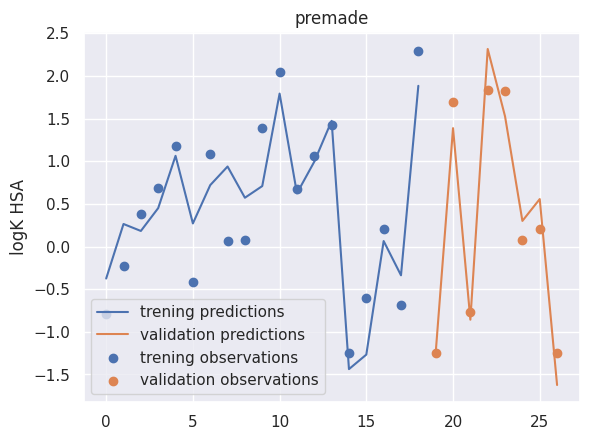

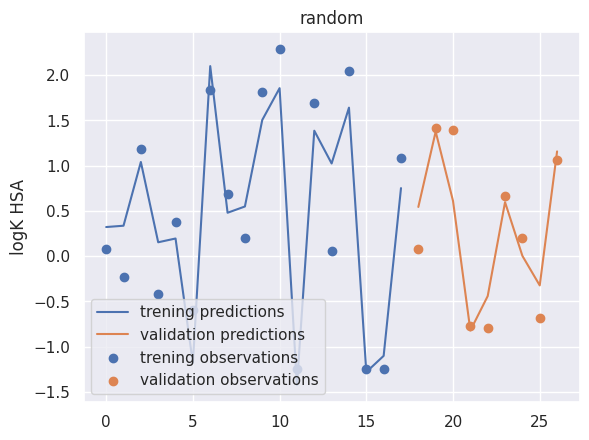

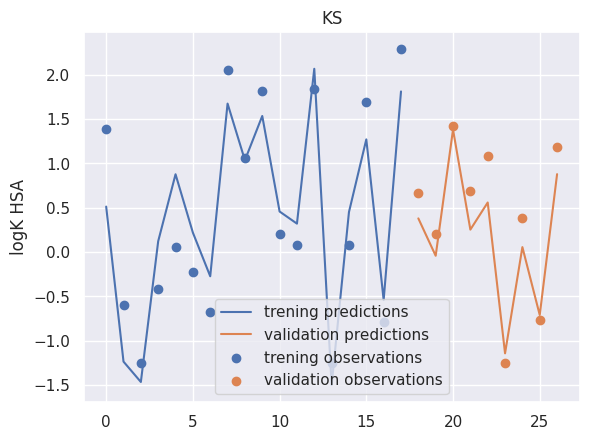

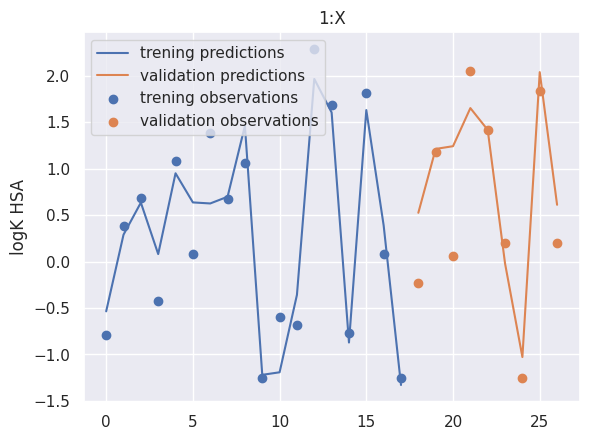

In [22]:
for method in partitioning_methods:
    plot_predictions(method)

In [ ]:
def plot_predictions_observations(method: str) -> None:
    
    plt.scatter(models[method].predict(X_training[method]).reshape(-1), Y_training[method], label="trening")
    plt.scatter(models[method].predict(X_validation[method]).reshape(-1), Y_validation[method], label="validation")
    plt.axline((0,0), (1,1), color='grey', linestyle='dotted')
    plt.title(method)
    plt.xlabel("predictions")
    plt.ylabel("observations")
    plt.legend()
    plt.show()

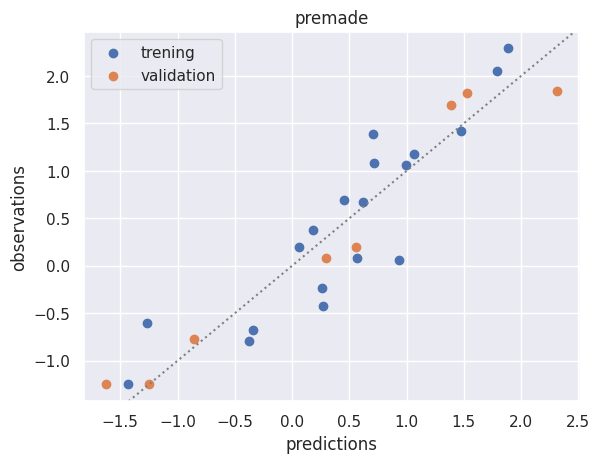

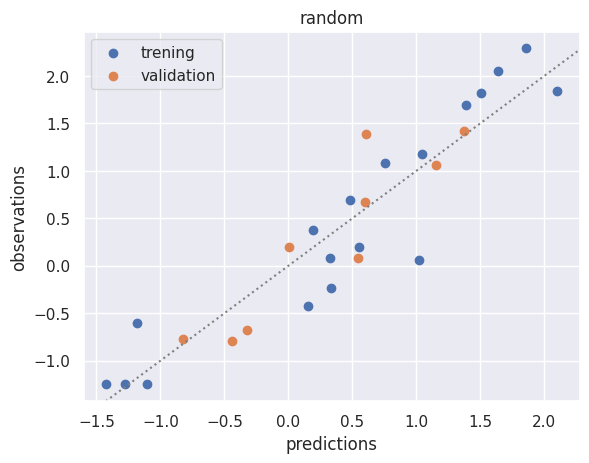

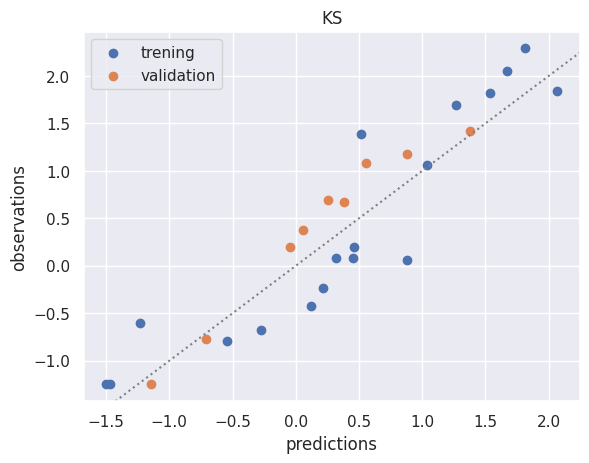

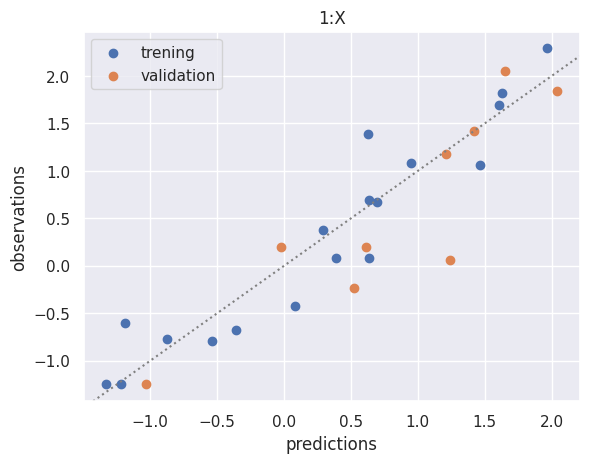

In [24]:
for method in partitioning_methods:
    plot_predictions_observations(method)

In [ ]:
def h_i(method: str, X: dict[pl.DataFrame]) -> pl.Series:

    return pl.Series(
        dot(

            dot(

                pl.Series(X[method].cast(pl.Float64).row(i)).reshape((1,-1)), 
                inv(
                    dot(

                        X[method].cast(pl.Float64).transpose(), 
                        X[method].cast(pl.Float64)
                        
                    )
                )

            ),
            pl.Series(X[method].cast(pl.Float64).row(i))

        )[0] for i in range(X[method].shape[0])
    )

In [26]:
h_i_training, h_i_validation = {}, {}

In [27]:
for method in partitioning_methods:
    h_i_training[method] = h_i(method, X_training)
    h_i_validation[method] = h_i(method, X_validation)

In [ ]:
def Williams_plot(method: str) -> None:
    
    h_star = 3*(X_training[method].shape[1]) / X_training[method].shape[0]

    trening_residuals = Y_training[method] - pl.Series(models[method].predict(X_training[method]).reshape(-1))
    stan_trening_residuals = trening_residuals.select((pl.col("logK HSA") - trening_residuals.mean()) / trening_residuals.std())

    walidacja_residuals = Y_validation[method] - pl.Series(models[method].predict(X_validation[method]).reshape(-1))
    stan_walidacja_residuals = walidacja_residuals.select((pl.col("logK HSA") - walidacja_residuals.mean()) / walidacja_residuals.std())

    plt.scatter(h_i_training[method], stan_trening_residuals, label="training")
    plt.scatter(h_i_validation[method], stan_walidacja_residuals, label="validation")
    plt.axvline(h_star, linestyle="dashed", color="grey")
    plt.axhline(-3, color='grey')
    plt.axhline(3, color='grey')
    plt.grid()
    plt.ylim(-3.5,3.5)
    plt.title(method)
    plt.xlabel("Leverages")
    plt.ylabel("Standardized residuals")
    plt.legend()
    plt.show()

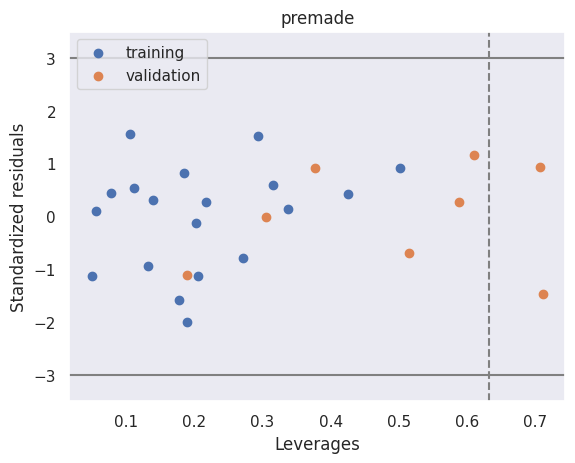

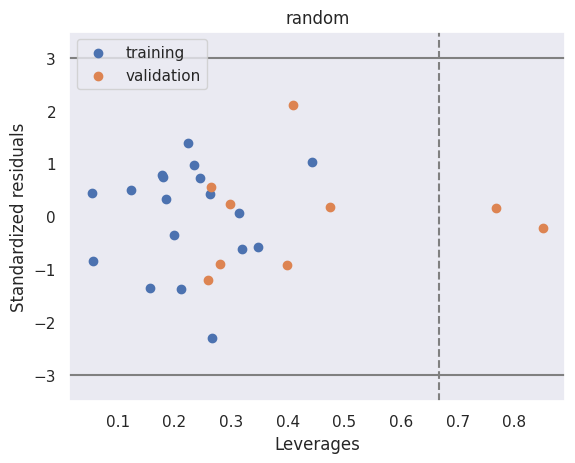

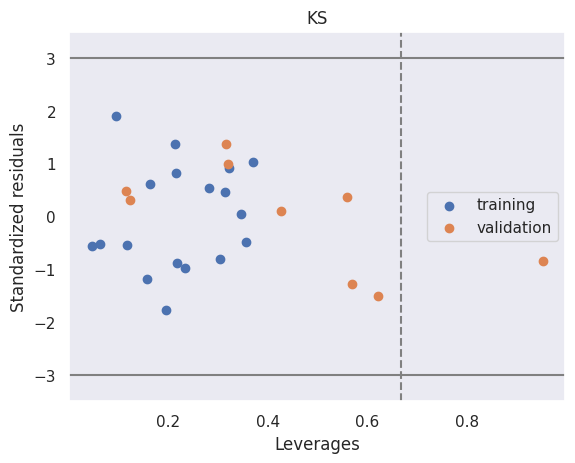

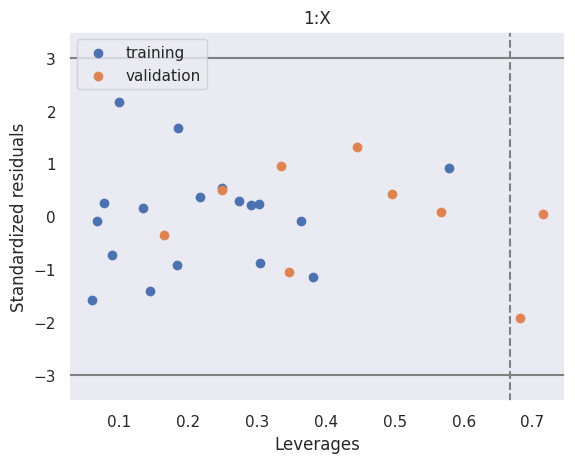

In [29]:
for method in partitioning_methods:
    Williams_plot(method)

In [30]:
for method in partitioning_methods:
    print(f"Method: {method}\tR2: {R2(models[method].predict(X_training[method]).reshape(-1), Y_training[method])}\tRMSE_c: {RMSE(models[method].predict(X_training[method]).reshape(-1), Y_training[method])}")

Method: premade	R2: 0.802627713030591	RMSE_c: 0.42710692427874286
Method: random	R2: 0.8742984445570606	RMSE_c: 0.40617313854232423
Method: KS	R2: 0.8488840411293017	RMSE_c: 0.4481301257715681
Method: 1:X	R2: 0.896360288316215	RMSE_c: 0.3426835481052738


In [ ]:
def leave_one_out(method: str) -> pl.Series:
    
    return pl.Series(
        [LinearRegression()
            .fit(
                X_training[method].with_row_index().filter(pl.col('index') != i).drop('index'),
                Y_training[method].with_row_index().filter(pl.col('index') != i).drop('index')
            )
            .predict(
                X_training[method].with_row_index().filter(pl.col('index') == i).drop('index')
            )[0][0] for i in range(X_training[method].shape[0])
        ] 
    )

In [32]:
LOO = {}

In [33]:
for method in partitioning_methods:
    LOO[method] = leave_one_out(method)
    print(f"Method: {method}\tQ2_cv: {Q2(LOO[method], Y_training[method])}\tRMSE_cv: {RMSE(LOO[method], Y_training[method])}")

Method: premade	Q2_cv: 0.6223963031006665	RMSE_cv: 0.5907607652603646
Method: random	Q2_cv: 0.7399707658331807	RMSE_cv: 0.584187098302314
Method: KS	Q2_cv: 0.7252418313545901	RMSE_cv: 0.6042606053843852
Method: 1:X	Q2_cv: 0.7812945498797035	RMSE_cv: 0.4978058084420117


In [34]:
def external_validation_model(method: str) -> pl.Series:

    return LinearRegression().fit(X_training[method], Y_training[method])

In [35]:
external_validation_models = {}

In [36]:
for method in partitioning_methods:
    external_validation_models[method] = external_validation_model(method)
    print(f"Method: {method}\tQ2_ext: {Q2(pl.Series(external_validation_models[method].predict(X_validation[method]).reshape(-1)), Y_validation[method])}\tRMSE_ext: {RMSE(pl.Series(external_validation_models[method].predict(X_validation[method]).reshape(-1)), Y_validation[method])}")

Method: premade	Q2_ext: 0.942439776973401	RMSE_ext: 0.3013587245888068
Method: random	Q2_ext: 0.8262765783188706	RMSE_ext: 0.35440921883599247
Method: KS	Q2_ext: 0.8722027837795137	RMSE_ext: 0.3014598156031032
Method: 1:X	Q2_ext: 0.739892937160161	RMSE_ext: 0.5204224532246602


In [37]:
Fs = {}

In [38]:
for method in partitioning_methods:
    Fs[method] = F(models[method].predict(X.select(pl.exclude("Nazwa"))).reshape(-1), Y.select(pl.exclude("Nazwa")), 4)
    print(f"Method: {method}\tF: {Fs[method]}")

Method: premade	F: 5.746799920517686
Method: random	F: 5.208816764174873
Method: KS	F: 4.838009010480896
Method: 1:X	F: 5.056599207073674


# Interpretacja

Jak widać, najlepsze predykcje dla zbioru walidacyjnego posiada model nauczony na pierwotnie stworzonym podziale. Jednak posiada on najgorsze zdolności predykcyjne dla zbioru treningowego oraz jest najmniej elastyczny, jak wynika z wartości $R^2$ oraz $Q^2_{cv}$. Nadal jednak jest on najbardziej istotny statystycznie, według statystyki F-Snedecora. Należy dodać, że w większości metod 2 związki ze zbioru walidacyjnego nie znalazły się w dziedzinie, dlatego nie jesteśmy w stanie przeprowadzić dla nich wiarygodnych predykcji.